In [207]:
# Data packages
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Math
import math
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# Import weights & Biases
import wandb


In [208]:
path = r'TF_HLC'

In [209]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq_1000.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

TTF_data = TTF_data
Vs_data = Vs_data

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(1000, 1000) (1000, 29) (1000,)


In [210]:
def f0_calc(Vs):
    """
    Calculate f0 from Vs data
    """
    # First eliminate nans in axis 0
    Vs = np.nan_to_num(Vs, nan=0.0)
    Vs = np.trim_zeros(Vs, trim='b')
    vs_value_1 = Vs[0]
    vs_value_2 = Vs[-1]
    h_soil = len(Vs[:-1])*5

    # Calculate f0
    f0 = vs_value_1 / (4*h_soil)
    return f0

In [211]:
f0_vals = []
for i in range(Vs_data.shape[0]):
    f0 = f0_calc(Vs_data[i])
    f0_vals.append(f0)

f0_vals = np.array(f0_vals)

# Filter only if f0 < 5
idx = np.where(f0_vals < 2)[0]

# Filter
TTF_data = TTF_data[idx]
Vs_data = Vs_data[idx]

print(TTF_data.shape, Vs_data.shape,freq_data.shape)

(836, 1000) (836, 29) (1000,)


In [212]:
# Convert all nan values to 0
Vs = np.nan_to_num(Vs_data, nan=0.0, posinf=0.0, neginf=0.0)

In [213]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = np.nan_to_num(self.Vs_values[idx], nan=0.0, posinf=0.0, neginf=0.0)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

# Load Models

## Seq2Seq

In [214]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [215]:
class CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Conv1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.MaxPool1d(2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.MaxPool1d(2))

        # Adaptive pooling layer to reduce sequence length to 1
        self.hidden_layers.append(nn.AdaptiveAvgPool1d(1))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation()(x)
        return x

In [216]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [217]:
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        h1, c1 = hidden
        attn_weights = self.attention(h1[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, (hidden, cell) = self.lstm(lstm_input, hidden)
        return outputs, (hidden, cell)

In [218]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        cell = self._cat_directions(cell)
        return outputs, (hidden, cell)

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

In [219]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None, cnn_1d_out=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d
        self.cnn_1d_out = cnn_1d_out

    def forward(self, x, device="cpu", print_shapes=False):
        # Replace Nan values with 0
        x = torch.nan_to_num(x, nan=0.0)


        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN-in output shape: ", x.shape)
        
        encoder_outputs, hidden = self.encoder(x)
        if print_shapes:
            print("Encoder outputs shape: ", encoder_outputs.shape)
            print("Hidden state shape: ", hidden[0].shape)  # Print hidden state
            print("Cell state shape: ", hidden[1].shape)    # Print cell state
        
        # Adjust decoder input to match encoder hidden size
        if hasattr(self.encoder, 'bidirectional') and self.encoder.bidirectional:
            decoder_input_size = self.encoder.hidden_size * 2
        else:
            decoder_input_size = self.encoder.hidden_size

        decoder_input = torch.zeros(x.size(0), 1, decoder_input_size).to(device)

        if print_shapes:
            print("Decoder input shape: ", decoder_input.shape)
        
        if hasattr(self.decoder, 'attention'):
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)
        else:
            output, hidden = self.decoder(decoder_input, hidden)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)
        
        if self.cnn_1d_out:
            output = self.cnn_1d_out(output)
            output = output.permute(0, 2, 1)
            if print_shapes:
                print("CNN-out output shape: ", output.shape)
        else:
            output = output.squeeze(1)
            if print_shapes:
                print("Squeezed output shape: ", output.shape)

        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output.squeeze(1)

In [220]:
# CNN Hyperparameters - In
input_size_cnn = 1
kernel_size = 2
hidden_dim_cnn = 10
hidden_layers_cnn = 2

# CNN Hyperparameters - Out
hidden_dim_cnn_out = 10
hidden_layers_cnn_out = 1


# Encoder and Decoder hyperparameters
input_size = 1 # Given the size of [batch_size, sequence_length, input_size] 
hidden_size = 100
num_layers = 3
encoder_bidirectional = True

# MLP hyperparameters
num_layers_fc = 3
hidden_size_fc = 200
output_size = 1000

# Model
cnn_1d = CNN_1D(input_size_cnn, kernel_size, hidden_dim_cnn, hidden_layers_cnn)
encoder = EncoderBiLSTM(input_size, hidden_size, num_layers)
if hasattr(encoder, 'bidirectional') and encoder.bidirectional:
    hidden_size *= 2
decoder = DecoderLSTMWithAttention(hidden_size, 1, num_layers)
cnn_1d_out = CNN_1D(1, 2, hidden_dim_cnn_out, hidden_layers_cnn_out)
mlp = MLP(200, hidden_size_fc, num_layers_fc, output_size)

model1 = Seq2Seq(encoder, decoder, mlp, cnn_1d=None, cnn_1d_out=None)

file_path = "best_model_RNN.pt"
if os.path.exists(file_path):
    model1.load_state_dict(torch.load(file_path))
    print("Model loaded successfully.")



Model loaded successfully.


C:\Users\kurt-\AppData\Local\Temp\ipykernel_6964\3636123906.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(file_path))


## FNO

In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes = modes
        self.width = width
        self.scale = (1 / (width ** 0.5))
        self.weights = nn.Parameter(self.scale * torch.randn(modes, width, width, 2, dtype=torch.float))
        self.linear_transform = nn.Linear(width, width)
        self.activation = nn.ReLU()

    def forward(self, x):
        batchsize, length, width = x.shape

        # Compute Fourier transform
        x_ft = torch.fft.rfft(x, dim=1, norm='ortho')

        # Preallocate tensor
        self.out_ft = torch.zeros(batchsize, length // 2 + 1, width, dtype=torch.cfloat, device=x.device)

        # Keep only the lower modes
        modes = min(self.modes, length // 2)
        indices = torch.arange(0, modes, device=x.device)

        # Complex multiplication of the low frequency modes
        self.out_ft[:, indices, :] = self.compl_mul1d(x_ft[:, indices, :], torch.view_as_complex(self.weights))

        # Return to physical space
        x_fourier = torch.fft.irfft(self.out_ft, n=length, dim=1, norm='ortho')

        # Apply the linear transformation in physical space
        x_linear = self.linear_transform(x)

        return self.activation(x_fourier + x_linear)
        
    def compl_mul1d(self, input, weights):
        return torch.einsum("bmw,mwo->bmo", input, weights)
    

In [222]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding='same') # Kernel size adjusted
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2) # Output size: 15
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding='same') # Output size: 15
        self.maxpool2 = nn.MaxPool1d(kernel_size=2) # Output size: 7
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding='same') # Output size: 7
        self.maxpool3 = nn.MaxPool1d(kernel_size=2) # Output size: 3
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding='same') # Output size: 3
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3 * 256, latent_dim) # Adjusted flattened size

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool3(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

class OperatorDecoder(nn.Module):
    def __init__(self, latent_dim, output_size, fno_modes, fno_width, fno_channels, dropout_rate=0.2):
        super(OperatorDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, fno_width * output_size)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(fno_width, output_size))
        self.fno1 = FNO1d(modes=fno_modes, width=fno_width)
        self.fno2 = FNO1d(modes=fno_modes, width=fno_width)
        self.fno3 = FNO1d(modes=fno_modes, width=fno_width)
        self.fc2 = nn.Linear(fno_width, 1)

    def forward(self, z):
        x = self.fc1(z)
        #x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.unflatten(x).permute(0, 2, 1) # Shape: (batch_size, output_size, fno_width)
        x = self.fno1(x)
        # Skip dropout after FNO1 since it operates in frequency domain
        x = self.fno2(x)
        x = self.fno3(x)
        #x = self.dropout(x)  # Apply after returning to spatial domain
        x = self.fc2(x).squeeze(-1) # Shape: (batch_size, output_size)
        return x

class EncoderOperatorModel(nn.Module):
    def __init__(self, input_size, latent_dim, output_size, fno_modes=16, fno_width=64, fno_channels=1, dropout_rate=0.2):
        super(EncoderOperatorModel, self).__init__()
        #self.encoder = Autoencoder(input_size, latent_dim)
        self.encoder = Encoder(input_size, latent_dim)
        self.operator_decoder = OperatorDecoder(latent_dim, output_size, fno_modes, fno_width, fno_channels, dropout_rate)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.operator_decoder(encoded)
        return decoded

# Define the input and output sizes
input_size = 29
output_size = 1000
latent_dim = 1000 # Adjust latent dimension as needed

# FNO parameters
fno_modes = 16
fno_width = 50
fno_channels = 1

# Create an instance of the model with the operator decoder
dropout_rate = 0.1
model2 = EncoderOperatorModel(input_size, latent_dim, output_size, fno_modes, fno_width, fno_channels, dropout_rate=dropout_rate)

# Path to weights
file_path = "best_ttf_model_1s1b.pt"

# Load the model weights
if os.path.exists(file_path):
    model2.load_state_dict(torch.load(file_path))
    print("Model weights loaded successfully.")

C:\Users\kurt-\AppData\Local\Temp\ipykernel_6964\3601116401.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(file_path))


Model weights loaded successfully.


In [223]:
x_dummy = torch.rand([100, 29])
model2(x_dummy).shape

torch.Size([100, 1000])

# Loading data

In [224]:
dataset = TTF_dataset(TTF_data, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  836
Data shapes for input and target:  torch.Size([29, 1]) torch.Size([1000])
Train, validation and test sizes:  668 84 84
Number of batches:  14 2 2


In [225]:
X, y = next(iter(train_loader))
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  torch.Size([50, 29, 1])
y shape:  torch.Size([50, 1000])


In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [227]:
# Set the model to evaluation mode
model1.eval()
model2.eval()
# Initialize lists to store predictions and targets
predictions1 = []
predictions2 = []
targets = []
test_inputs = []

# Move models to the same device as the data
model1.to(device)
model2.to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    for inputs, target in test_loader:
        # Move inputs to the same device as the model
        inputs = inputs.to(device)
        target = target.to(device)
        print(inputs.shape, target.shape)

        # Get predictions from both models
        pred1 = model1(inputs, device=device, print_shapes=False)
        pred2 = model2(inputs.squeeze(-1))

        # Store predictions and targets
        predictions1.append(pred1.cpu().numpy())
        predictions2.append(pred2.cpu().numpy())
        targets.append(target.cpu().numpy())
        test_inputs.append(inputs.cpu().numpy())

# Concatenate all predictions and targets
predictions1 = np.concatenate(predictions1, axis=0)
predictions2 = np.concatenate(predictions2, axis=0)
targets = np.concatenate(targets, axis=0)
test_inputs = np.concatenate(test_inputs, axis=0)


torch.Size([50, 29, 1]) torch.Size([50, 1000])
torch.Size([34, 29, 1]) torch.Size([34, 1000])


In [228]:
# Calculate the correlation coefficient in axis=0
from scipy.stats import pearsonr

corr_coefficients_1 = []
corr_coefficients_2 = []

for i in range(predictions1.shape[0]):
    corr_1, _ = pearsonr(predictions1[i, :], targets[i, :])
    corr_2, _ = pearsonr(predictions2[i, :], targets[i, :])
    corr_coefficients_1.append(corr_1)
    corr_coefficients_2.append(corr_2)

# Array
corr_coefficients_1 = np.array(corr_coefficients_1)
corr_coefficients_2 = np.array(corr_coefficients_2)

In [234]:
print(corr_coefficients_1.shape, corr_coefficients_2.shape)

(84,) (84,)


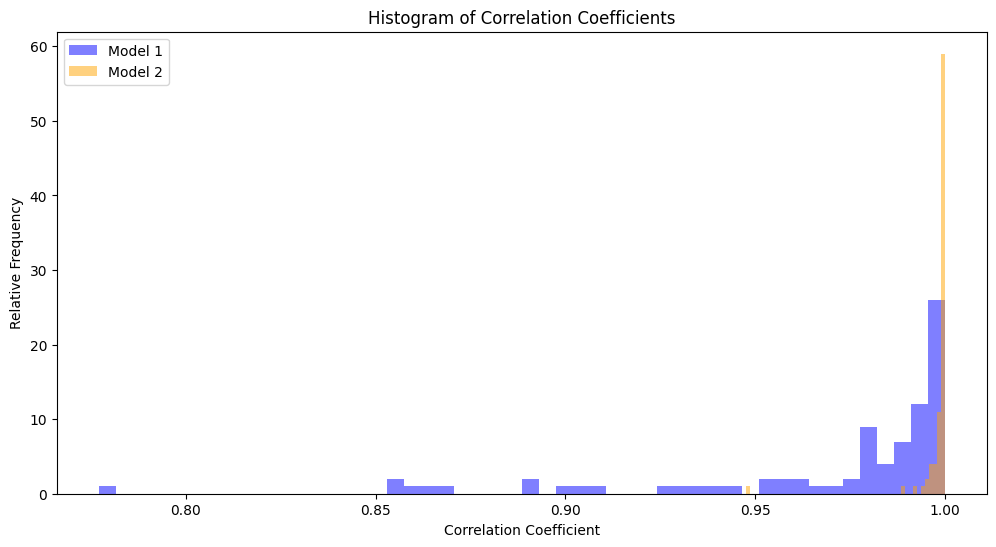

In [236]:
# Compare the histograms
plt.figure(figsize=(12, 6))
plt.hist(corr_coefficients_1, bins=50, alpha=0.5, label='Model 1', color='blue')
plt.hist(corr_coefficients_2, bins=50, alpha=0.5, label='Model 2', color='orange')

plt.xlabel('Correlation Coefficient')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Correlation Coefficients')
plt.legend()

In [230]:
def text_plot(Vs, correlation):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    # Trim zeros of the end
    Vs = np.trim_zeros(Vs, trim='b')
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1]) * 5
    vs_bedrock = Vs[-1]
    return f"$Vs_1:$ ${vs_soil:.0f}$ m/s, $Vs_2:$ ${vs_bedrock:.0f}$ m/s\n$h:$ ${h_soil}$ m"

def freq_calc(Vs):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1]) * 5
    return vs_soil/(4*(h_soil+5))

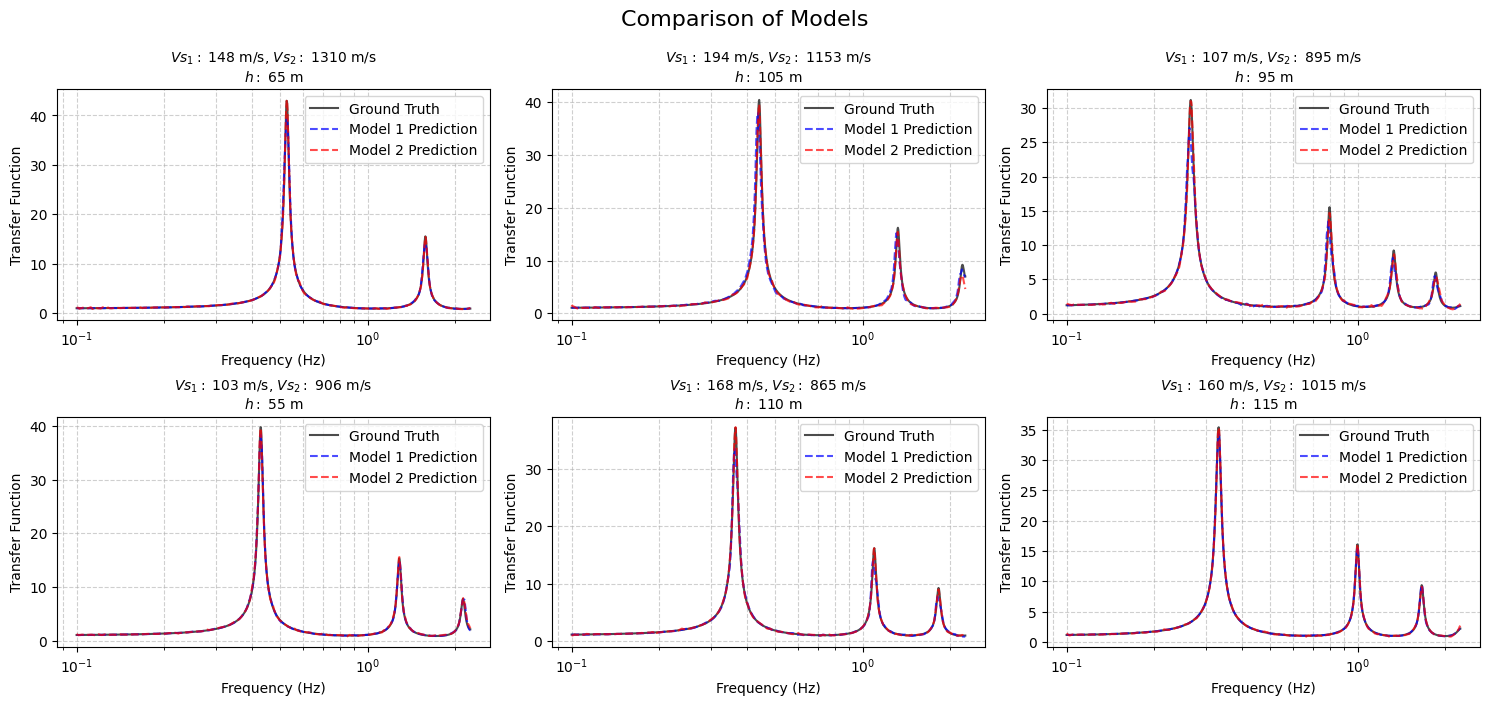

In [231]:
# Select 6 random indices from the test set
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(test_dataset), size=6, replace=False)

# Create a figure to plot the 5 random examples
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    
    # Plot the target (ground truth)
    plt.plot(freq_data, targets[idx], 'k-', label='Ground Truth', alpha=0.7)
    
    # Plot the prediction
    plt.plot(freq_data, predictions1[idx], 'b--', label='Model 1 Prediction', alpha=0.7)
    plt.plot(freq_data, predictions2[idx], 'r--', label='Model 2 Prediction', alpha=0.7)

    # Legend
    plt.legend(loc='upper right')
    
    # Show input Vs value
    vs_value = test_inputs[idx]
    test_val = text_plot(vs_value, corr_coefficients_2[idx])
    plt.title(test_val, fontsize=10)
    
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    
    # Only add legend to the first subplot
    if i == 0:
        plt.legend()
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Transfer Function')

plt.tight_layout()
plt.suptitle('Comparison of Models', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()